### 2 in the title means it is based on the simulated dataset

#### Setup 

In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

config = Dataset_load.load_config()
colors = config["colors"]["three"]
import ast

colors[1] = ast.literal_eval(colors[1])
colors[2] = ast.literal_eval(colors[2])
colors[3] = ast.literal_eval(colors[3])

#import seaborn as sns


alpha_nui = 0.99
alpha_st = 0.99
legendsscatter = ["Asimov w/o nui.", "Asimov with nui."]
legends = ["", ""]

alpha_rnd = 0.2
alpha_rnd_nui = 0.2

nbins = 20

In [3]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6, color = 'red'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label, color = color)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j], 
                        color = colors [j])
            except:
                pass

    plt.tight_layout()
    return fig

markersize = [6,10, 10]


def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_input.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-14, 2e-12)

## Dataset

In [4]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
#lambda_ = Parameter("lambda_", value=1/60)

dataset_input = Dataset_load.create_asimov(
    model="pl", 
    source="PKSflare", 
    parameters=Parameters([scaled_amplitude])
)
source_model = dataset_input.models[0].copy()
emask = dataset_input.mask.data.sum(axis=2).sum(axis=1)>0
energy = dataset_input.geoms['geom'].axes[0].center
energy_mask = dataset_input.geoms['geom'].axes[0].center[emask]

loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


## Systematic Settings

In [5]:
# bkg sys
magnitude = 10 # in percent
corrlength = 2 # correlation length  in terms of energy bins
seed = 38

bias = 0.1
resolution= 0.
norm = 0.1
tilt = 0.02

In [6]:
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
dataset_asimov_N.models.parameters['resolution'].frozen = True
dataset_asimov_N.irf_model.parameters['tilt'].frozen = False


setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
# piece wise model
# remove old bkg model
setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
setup.set_piecewise_bkg_model(dataset_asimov_N)
setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
# energy of the following parameters smaller than ethrshold
dataset_asimov_N.background_model.parameters['norm0'].frozen = True
dataset_asimov_N.background_model.parameters['norm1'].frozen = True
dataset_asimov_N.background_model.parameters['norm2'].frozen = True
dataset_asimov_N.background_model.parameters['norm3'].frozen = True
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: IRFModels

  Name                      : 2P3dEddY-irf
  Datasets names            : 2P3dEddY
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffAreaIRFModel
  PSF model type            : 
  Parameters:
    bias                          :      0.000   +/-    0.00             
    resolution            (frozen):      0.000                

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

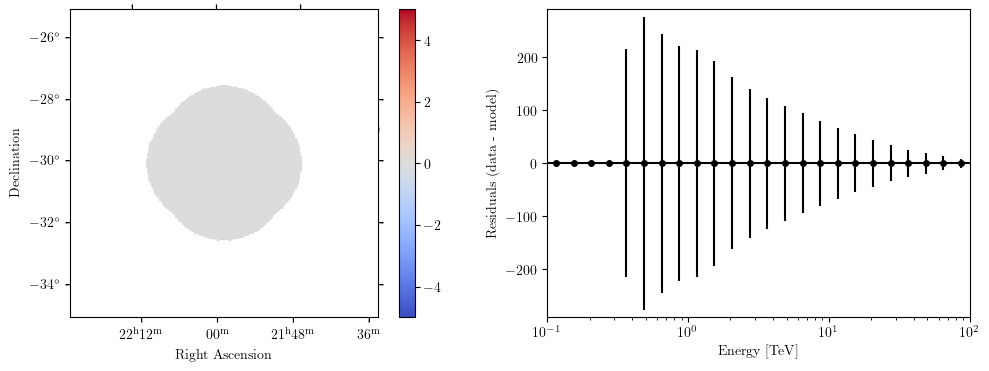

In [7]:
dataset_asimov.plot_residuals()

## Fit

In [8]:
%%time
fitting = 0
path1 = f'data/1_asimov.yml'
path2= f'data/1_asimov_nui.yml'


if fitting:

    fit = Fit()
    fit.run(dataset_asimov)
    dataset_asimov.models.write(path1,overwrite=True)
    
    fit.run(dataset_asimov_N)    
    dataset_asimov_N.models.write(path2,overwrite=True)
    
else:
    dataset_asimov.models = Models.read(path1)
    dataset_asimov_N.models = Models.read(path2)
    
    
    

CPU times: user 157 ms, sys: 12.4 ms, total: 169 ms
Wall time: 157 ms


In [9]:
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.07             
    amplitude                     :   1.00e-12   +/- 1.2e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         




#### Best-Fit Parameters

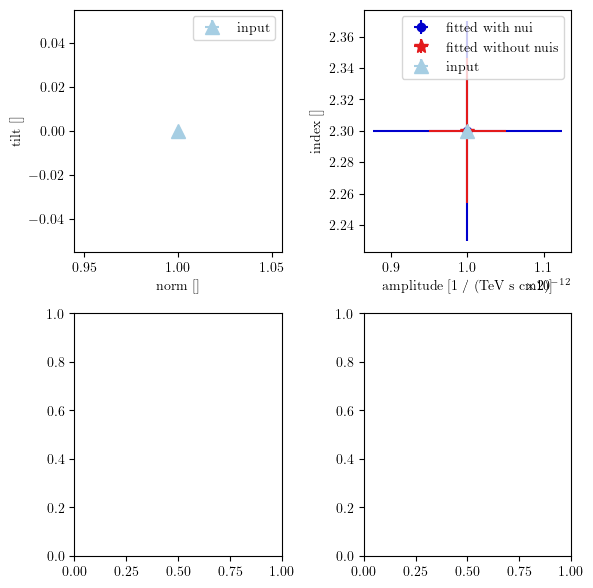

In [10]:
models_list = [ dataset_asimov_N.models ,dataset_asimov.models,  dataset_input.models]
labels = [ 'fitted with nui','fitted without nuis', 'input']
fmts = ['o','*', '^', ]

pars =  pars = [('norm', 'tilt'),('amplitude', 'index'),
               ('lambda_', 'lambda_')]
ax = plot_source_par(0, pars)


In [11]:
for p in ['amplitude', 'index']:
    print(p)
    for i, d in enumerate([dataset_asimov_N, dataset_asimov, dataset_input]):
        pp = d.models[0].parameters[p]
        print(f"{labels[i]}")
        if p == 'lambda_':
            print(f"$1/{(1/pp.value):.3} \pm 1/{(pp.error/pp.value**2):.3}$")   
        if p == 'amplitude':
            print(f"${pp.value*1e12:.2} \pm {pp.error*1e12:.2}$")   
            
        else:
            print(f"${pp.value:.4} \pm {pp.error:.4}$")   
        
    print()

amplitude
fitted with nui
$1.0 \pm 0.12$
fitted without nuis
$1.0 \pm 0.051$
input
$1.0 \pm 0.0$

index
fitted with nui
$2.3 \pm 0.07038$
fitted without nuis
$2.3 \pm 0.04634$
input
$2.3 \pm 0.0$



## Fluxpoints

In [12]:
comput_fp = 0
if comput_fp :
    energy_edges = dataset_asimov.geoms["geom"].axes[0].edges[::2]
    esti = FluxPointsEstimator(energy_edges=energy_edges)
    fluxpoints = esti.run([dataset_asimov])
    fluxpoints.write(
        "data/fluxpoints/2_fluxpoints_asimov.fits", overwrite = True
    )
    Models([dataset_asimov.models[0]]).write(
        "data/fluxpoints/2_model_asimov.fits" , overwrite = True
    )
    
    fluxpoints_N = esti.run([dataset_asimov_N])
    fluxpoints_N.write(
        f"data/fluxpoints/2_fluxpoints_asimov_N.fits", overwrite= True,
    )
    Models([dataset_asimov_N.models[0]]).write(
        f"data/fluxpoints/2_model_asimov_N.fits", overwrite= True,
    )
    
    fp_asimov = FluxPointsDataset(data = fluxpoints, models = Models([dataset_asimov.models[0]]))
    fp_asimov_N = FluxPointsDataset(data = fluxpoints_N, models = Models([dataset_asimov_N.models[0]]))
    
else:
    fp_asimov = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov.fits"),
                                 models = Models.read("data/fluxpoints/2_model_asimov.fits"))
    fp_asimov_N = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov_N.fits"),
                                 models = Models.read("data/fluxpoints/2_model_asimov_N.fits"))

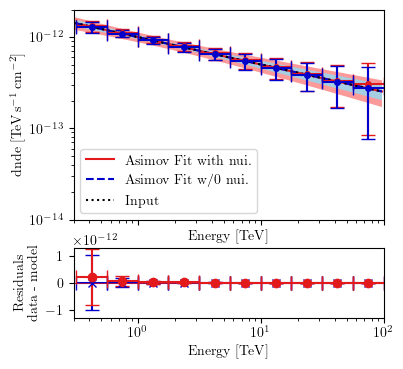

In [13]:
fp_asimov = FluxPointsDataset(
    data=FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov.fits"),
    models=Models.read("data/fluxpoints/2_model_asimov.fits"),
)
fp_asimov_N = FluxPointsDataset(
    data=FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov_N.fits"),
    models=Models.read("data/fluxpoints/2_model_asimov_N.fits"),
)


energy_power = 2
fig, axs = plt.subplots(2, 1, figsize=(4, 4), sharex=True, gridspec_kw={"height_ratios": [3, 1]},)
plot_asimov_spectrum(fig, axs[0])
fp_asimov_N.data.plot(energy_power=2, color=colors[1], ax=axs[0], capsize = 5)
fp_asimov.data.plot(energy_power=2, color=colors[0], ax=axs[0], capsize = 5)


fp_asimov.plot_residuals(ax =axs[1], color = colors[0], capsize = 5, marker = 'x')
fp_asimov_N.plot_residuals(ax =axs[1], color = colors[1],  capsize = 5, marker = 'o')

axs[0].set_xlim(0.3, 100)
fig.savefig("plots/1_fluxpoints_spectrum.pdf", bbox_inches="tight")
fig.savefig("plots/1_fluxpoints_spectrum.png", bbox_inches="tight")

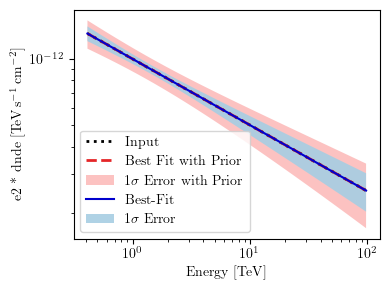

In [14]:
energy_bounds = (0.4, 100  ) * u.TeV

fig,axs = plt.subplots(1,1,figsize = (4,3))
energy_power=2
dataset_input.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power, ax =axs, 
                                label = "Input", color = 'black', linewidth = energy_power, linestyle="dotted")
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,color = colors[1],
                                                         label="Best Fit with Prior",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[3],
                                                         label="$1\sigma$ Error with Prior",
                                                        alpha = 0.6)

dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "Best-Fit", color = colors[0])

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[2],
                                                          alpha = 0.9,
                                                          label= "$1\sigma$ Error"
                                                         )

axs.legend() 
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_comparison.png", dpi = 300)

## Correlation Matrix

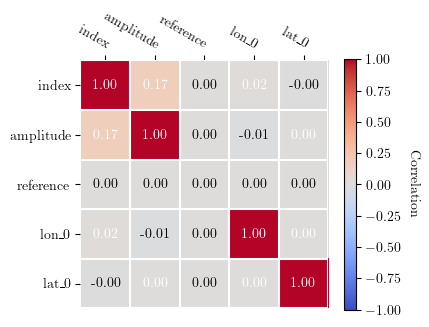

In [15]:
ax = dataset_asimov_N.models.covariance.plot_correlation()


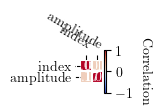

In [16]:
par_names = ['index', 'amplitude', 'lambda_', 'bias',  'norm' , 'tilt']

#dataset_asimov_N.models.read_covariance("data", f"2_model_nui_covariance.dat", format="ascii.fixed_width")
parameters = Parameters([_ for _ in dataset_asimov_N.models.parameters if _.name in par_names])
cov_par = dataset_asimov_N.models.covariance.get_subcovariance(parameters)

ax = cov_par.plot_correlation()
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_covmatrix_combination.png")